In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2022-11-26 15:03:26.362572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 15:03:26.947188: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-26 15:03:26.947236: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-26 15:03:26.947240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT librar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

import jax
from jax import jit

import tensorflow_datasets as tfds
from tqdm import tqdm

/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(42)

In [4]:
# Download MNIST
dataset_name = 'MNIST'
num_classes = 10
size = 32
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)

In [5]:
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float64)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(num_classes)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

test_x_copy = test_x.copy()

$k(x, y) = \theta_1 \exp\left(-\frac{1}{2}\frac{||x - y||^2}{\theta_2}\right)$

In [7]:
@jit
def kernel(x, y, theta1=1., theta2=1.):
    k = (
        jnp.sum(jnp.square(x), axis=1).reshape(-1, 1)
        + jnp.sum(jnp.square(y), axis=1)
        - 2 * x @ y.T
    )
    return theta1 * jnp.exp(-0.5 / theta2 * k)

In [8]:
K_train = kernel(train_x, train_x)
K_test = kernel(train_x, test_x)

2022-11-26 15:03:37.843309: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:492] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
K_train = jax.device_get(K_train)
K_test = jax.device_get(K_test)

In [10]:
K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-5 * jnp.eye(K_train.shape[0]))

In [11]:
pred_jax = K_test.T @ K_inv @ train_y

In [12]:
y_pred = np.argmax(pred_jax, axis=-1)
gt = np.argmax(test_y, axis=-1)
accuracy = np.mean(y_pred == gt)
accuracy

DeviceArray(0.96999997, dtype=float32)

In [13]:
@jit
def loss_fn(train_x, test_x, train_y, test_y, K_inv):
    k_test = kernel(train_x, test_x)
    pred = k_test.T @ K_inv @ train_y
    loss = (0.5 * (pred - test_y) ** 2).mean()
    return loss

@jit
def evaluate(train_x, test_x, train_y, test_y, K_inv):
    k_test = kernel(train_x, test_x)
    pred = k_test.T @ K_inv @ train_y
    y_pred = jnp.argmax(pred, axis=-1)
    gt = jnp.argmax(test_y, axis=-1)
    accuracy = jnp.mean(y_pred == gt)
    return y_pred, accuracy

@jit
def update(train_x, test_x, train_y, test_y, K_inv, epsilon=0.1, delta=0.3):
    grad = jax.grad(loss_fn, argnums=1)(train_x, test_x, train_y, test_y, K_inv)
    grad = jnp.reshape(grad, test_x.shape)
    x_adv = test_x + epsilon * jnp.sign(grad)
    x_adv = jnp.clip(x_adv, a_min=test_x - delta, a_max=test_x + delta)
    return x_adv

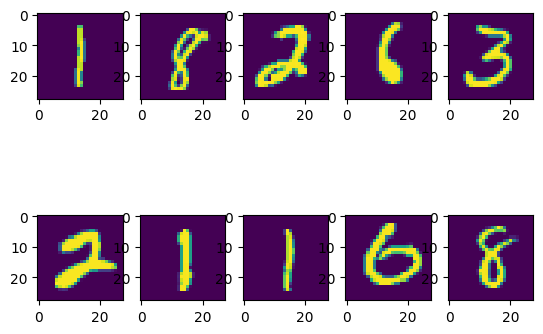

In [14]:
x = test_x_copy[:10]
cnt = 0
ncol, nrow = 5, 2
for i in range(ncol * nrow):
    cnt += 1
    plt.subplot(nrow, ncol, cnt)
    plt.imshow(x[i].reshape(28, 28, 1))
plt.show()

In [15]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((20000, 784), (10000, 784), (20000, 10), (10000, 10))

In [16]:
x = test_x_copy.copy()

pred, acc = evaluate(train_x, x, train_y, test_y, K_inv)
before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

num_iteration = 10

acc_list = list()
for step in tqdm(range(num_iteration)):
    x = update(train_x, x, train_y, test_y, K_inv, epsilon=0.1, delta=2e-3)
    x = x / jnp.linalg.norm(x, axis=1)[:, None]
    _, acc = evaluate(train_x, x, train_y, test_y, K_inv)
    acc_list.append(acc)

pred, acc = evaluate(train_x, x, train_y, test_y, K_inv)
after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


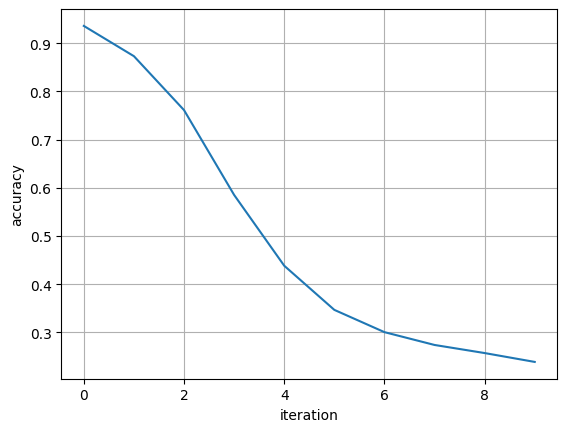

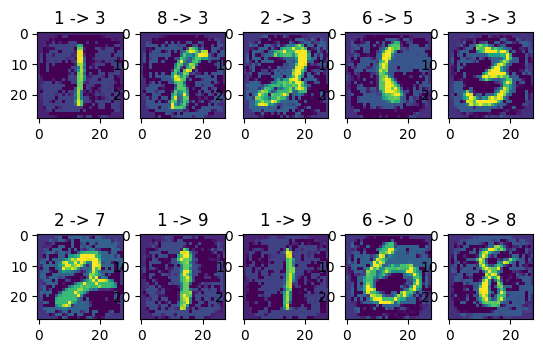

In [17]:
plt.plot(acc_list)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.grid()
plt.show()

cnt = 0
ncol, nrow = 5, 2
for i in range(ncol * nrow):
    cnt += 1
    before_pred = before['pred'][i]
    after_pred = after['pred'][i]
    plt.subplot(nrow, ncol, cnt)
    plt.title(f'{before_pred} -> {after_pred}')
    plt.imshow(x[i].reshape(28, 28, 1))
plt.show()

In [18]:
print(f'Accuracy: {before["acc"]} -> {after["acc"]}')

Accuracy: 0.9699999690055847 -> 0.23879998922348022
